In [8]:
# Thoomas Goldman 2023
# DOLPHINN

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import tensorflow as tf

sys.path.append("..")

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.dynamics import TwoBodyProblemRadialThetaNonDimensionalControl_mass
from DOLPHINN.output_layers import InitialFinalStateLayer_RadialTheta_tanh_mass
from DOLPHINN.objectives import OptimalFuel
from DOLPHINN.training import Scheduler, Restarter
from DOLPHINN.metrics import FinalDr, FinalDv, FinalDm, Fuel, 

from DOLPHINN import plotting
from DOLPHINN import utils

In [9]:

# Constants
mu = 1.32712440042e20 # SUN
m = 100 # spacecraft initial mass
AU = 1.5e11 #EARTH-SUN
a = 10 # steepness parmaters in constraints
umax = 0.1 # maximum thrust
isp = 2500 # specific impulse

# From 1 AU (Earth) to 1.5 AU (Mars) 
rp = AU
ra = 1.5*AU

# Initial state
r0 = rp
theta0 = 0
vr0 = 0
vt0 = np.sqrt(mu/r0)
initial_state = np.array([r0, theta0, vr0, vt0])

# Final state
rfinal = ra
theta_final = 1.5*np.pi
vr_final = 0
vt_final = np.sqrt(mu/rfinal)
final_state = np.array([rfinal, theta_final, vr_final, vt_final])

# Non dimensionalize
length_scale = r0
time_scale = length_scale / vt0

# Initial states in non-dimensional units
initial_state[:1] = initial_state[:1]/length_scale
initial_state[2:] = initial_state[2:]*time_scale/length_scale

# Initial states in non-dimensional units
final_state[:1] = final_state[:1]/length_scale
final_state[2:] = final_state[2:]*time_scale/length_scale


# Integration times
t0 = 0
tfinal = 350*24*3600 # Constant time of flight
N = 200 # Collocation points sampld per training epoch 

# Network architecture
input_dimension = 1 # Only Time
output_dimension = 7 # 4 state entries, 1 mass entry and 2 control entries
layer_size = [1, 20, 20, 20, 20, 7] # Acrhictecture (a single(!) fully connected feed-forward neural network)

# Collect everything
data = {"initial_state": initial_state,
        "final_state": final_state,
        "m": m,
        "mu": mu,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0/time_scale,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

In [13]:
# Define the DOLPHINN 
# Second argument is the loss function
# output_transform argument is the constraint layer
# objective is the objective loss term. 
# metrics calculate the displacmeent in r (FinalDr), v (FinalDv), m (FinalDm) by comparison to
# propagation of the initial state, control profile with the same acceleration model as used in the 
# loss, but performed by tudat. It does so during training, after each test run I believe!
problem = DOLPHINN(data,
                    TwoBodyProblemRadialThetaNonDimensionalControl_mass,
                    output_transform = InitialFinalStateLayer_RadialTheta_tanh_mass,
                    objective = OptimalFuel, 
                    metrics = [FinalDr, FinalDv, FinalDm, Fuel])

# Loss-term-weight
mweigth = 1e-5 # mass term
oweigth = 1e-7 # objective term

# This is a training schedule that restarts if the loss is not below "Loss_threshold" after the schedule
restarter = Restarter([(1e-2, 3000), (1e-3, 5000)], loss_threshold = 5, loss_weigths = [1, 1, 1, 1, mweigth, oweigth])

# This is training schedule that performs a sequence of trainings denoted as [(learning_rate, epochs), (learning_rate, epoch)] 
schedule  = Scheduler([(1e-3, 5000), (1e-4, 10000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000), (1e-5, 6000)],
                       loss_weigths = [1, 1, 1, 1, mweigth, oweigth])

# This actually initiates the training
problem.train([restarter, schedule])

[DOLPHINN] Using time-dependent random seed: 20241004204808

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.000483 s

Training model...

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Step      Train loss                                                      Test loss                                                       Test metric                                 
0         [2.41e+00, 6.91e+02, 2.23e+11, 3.87e+00, 3.82e-02, 3.65e-06]    [1.72e+00, 6.44e+01, 3.35e+08, 1.53e+00, 2.60e-02, 3.65e-06]    [7.66e-01, 4.17e-01, -1.90e+01, 3.65e+01]   
1000      [3.43e+01, 3.01e-01, 1.44e+02, 7.29e+00, 8.59e-02, 9.46e-06]    [2.62e+01, 1.98e-01, 7.92e+00, 5.67e+00, 6.38e-02, 9.46e-06]    [1.56e+00, 1.46e+00, 2.27e+01, 9.46e+01]    
2000      [3.43e+01, 2.30e-01, 1.35e+02

In [14]:
# This prints the configuration of the DOLPHINN class instance
# Very usefull is the exact sequence of training that has been performed is stored. 
problem.print_config()


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialThetaNonDimensionalControl_mass
input_transform                NoneType
output_transform               InitialFinalStateLayer_RadialTheta_tanh_mass
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 0.0, 1.0]
final_state                    [1.5, 4.71238898038469, 0.0, 0.816496580927726]
m                              100
mu                             1.32712440042e+20
a                              10
umax                           0.1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0.0
tfinal                         5.996539728406368

----------Network----------
architecture                   [1, 20, 20, 20, 20, 7]
activation                     sin
sampler               

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.0675 s


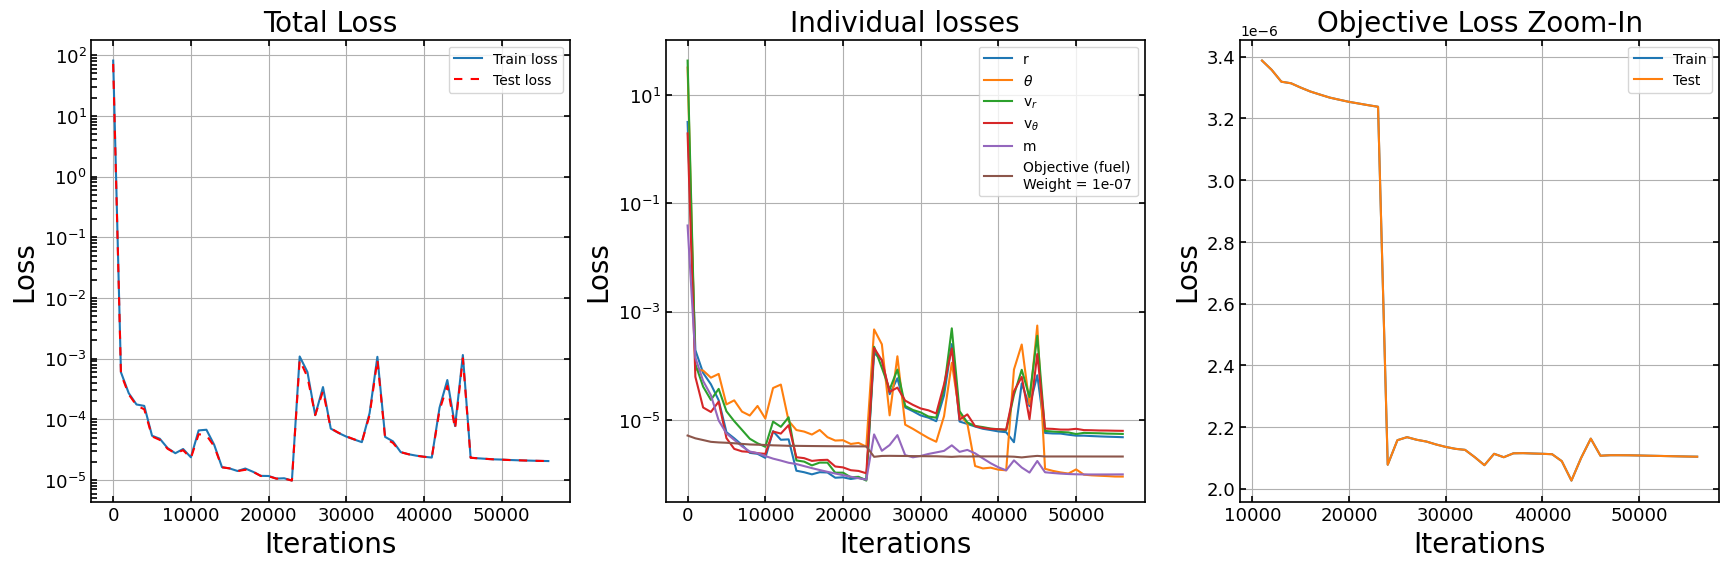

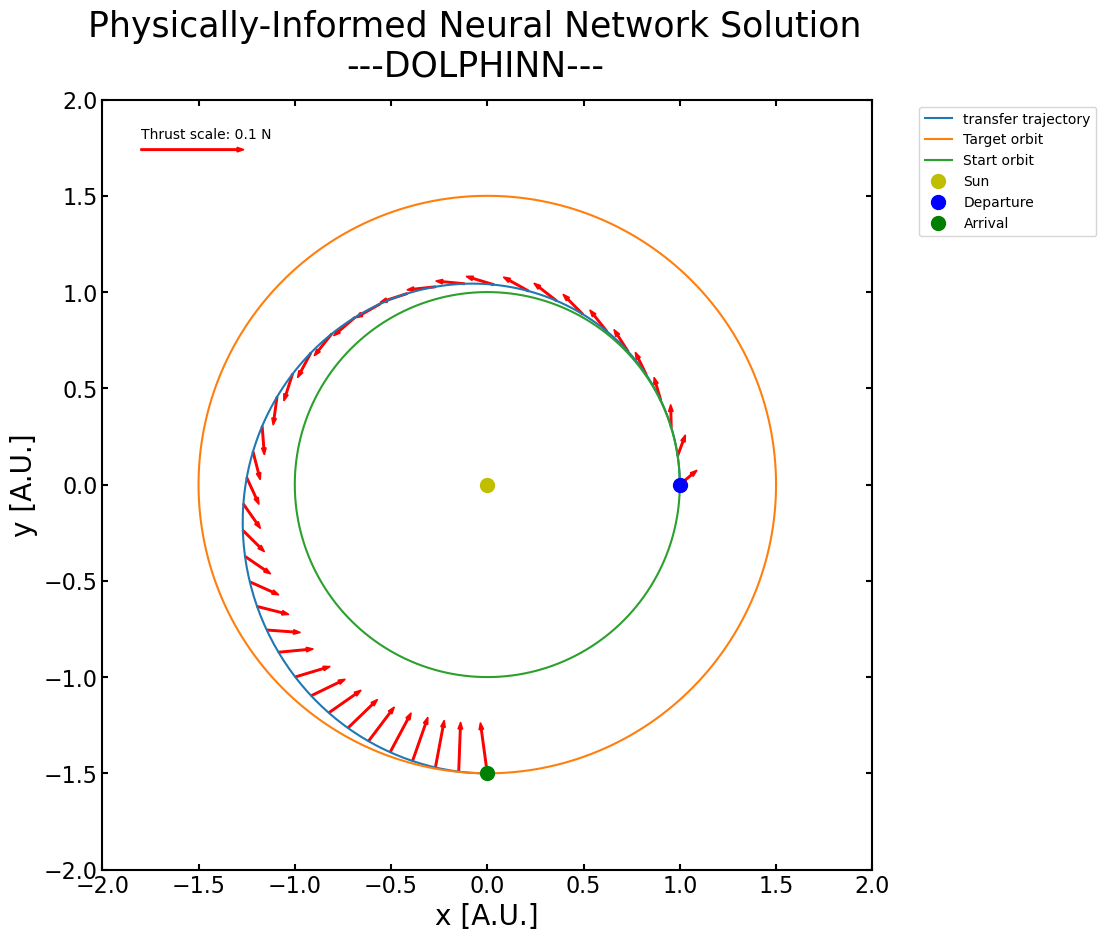

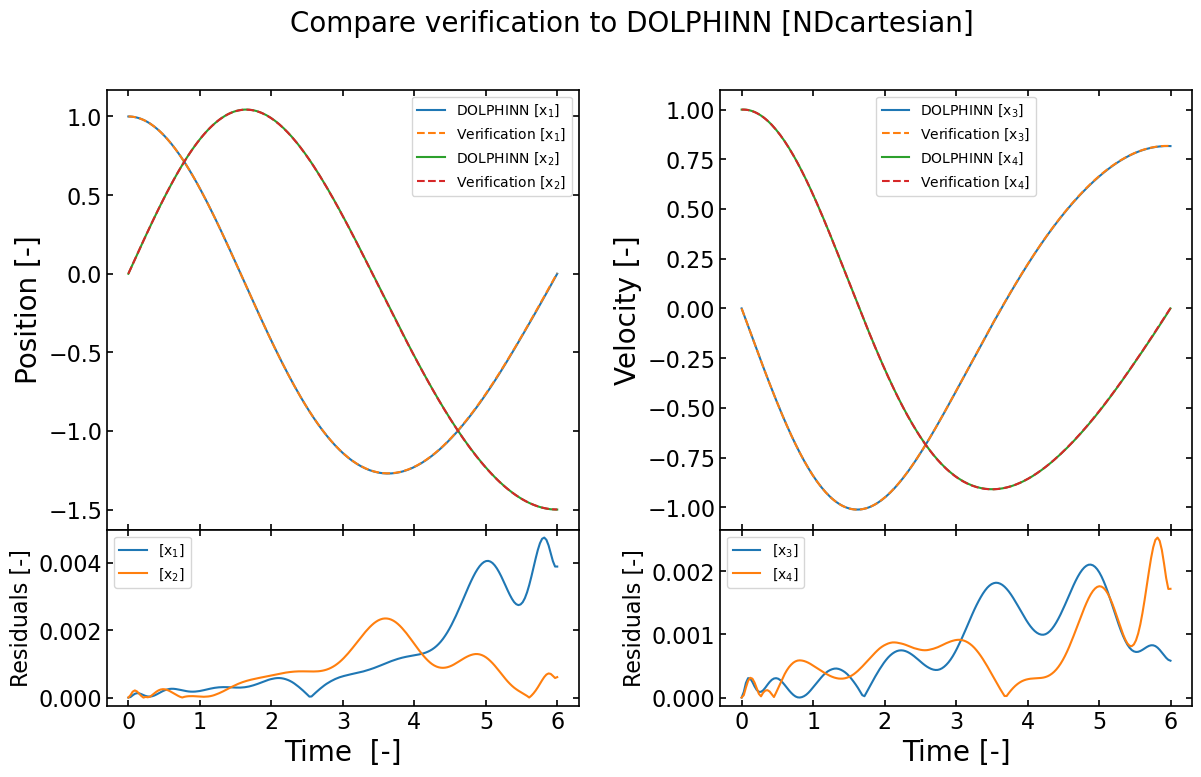

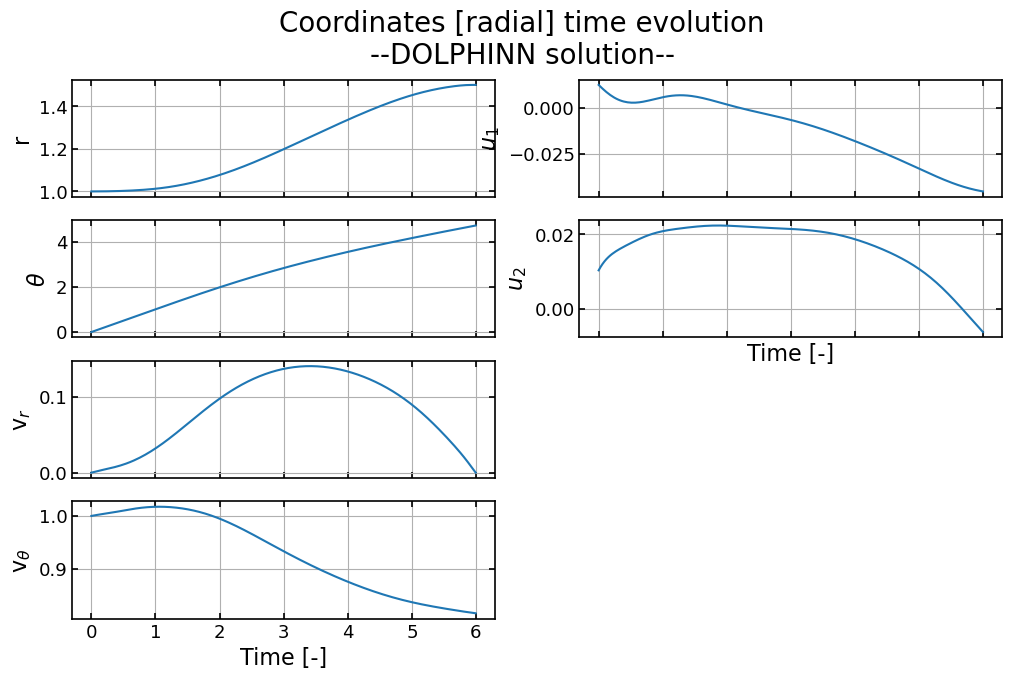

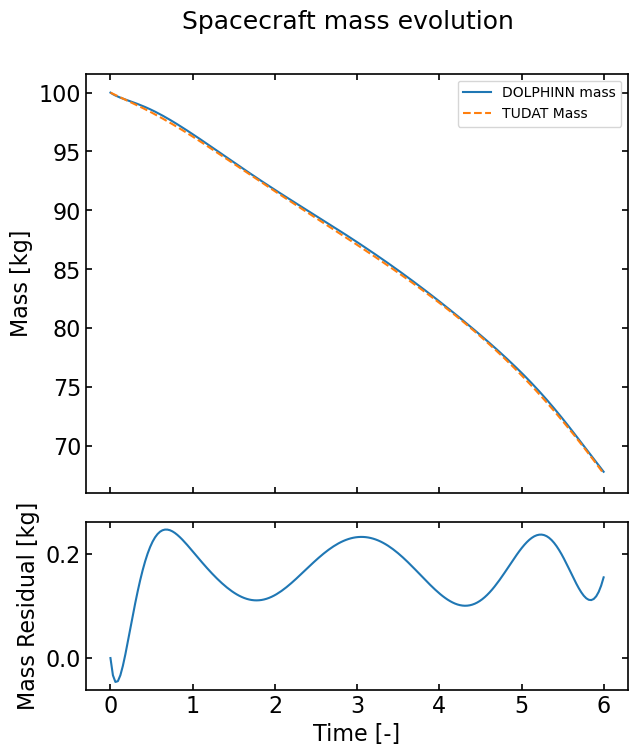

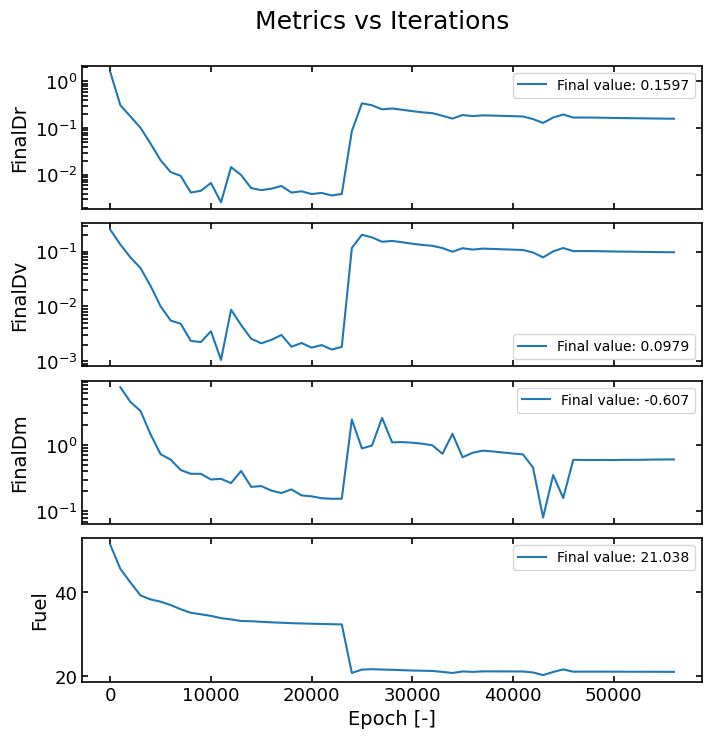

In [15]:
# Now lets do some plotting
# (In this example note that the best case is at epoch ~23000 and not at the end). 
problem.verify()
plotting.plot_loss(problem, objective_zoom=True)  
plotting.plot_transfer(problem, bench = False, thrust_scale = 0.1, r_start = rp/length_scale, r_target = final_state[0], N_arrows = 40, lim = 2)
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial")
plotting.compare_mass(problem)
plotting.plot_metrics(problem)

In [16]:
# Store all information on this DOLPHINN instance
problem.store("Data/folder/", overwrite = False)

Saving loss history to Data/folder/loss.dat ...
Saving training data to Data/folder/train.dat ...
Saving test data to Data/folder/test.dat ...
[DOLPHINN] Saving config file to Data/folder/config


In [17]:
# Load the case back into a dolphinn class by passing the folder where the 
# configuration is stored.

path = f"Data/folder/"
problem_loaded = DOLPHINN.from_solution(path, verbose = True)


[DOLPHINN] Initializing the DOLPHINN from old solution at: Data/folder/
[DOLPHINN][Warning] Upload of seed requested but initialisation will be overwritten by the solution
[DOLPHINN] Config file succesfully parsed. Initializing DOLPHINN with:

 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialThetaNonDimensionalControl_mass
input_transform                None
output_transform               InitialFinalStateLayer_RadialTheta_tanh_mass
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 0.0, 1.0]
final_state                    [1.5, 4.71238898038469, 0.0, 0.816496580927726]
m                              100
mu                             1.32712440042e+20
a                              10
umax                           0.1
isp                            2500
length_scale                   150000000000.0
time_scale                     504